In [1]:
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
# from mpl_finance import candlestick_ohlc
import mplfinance as mpf

from binance.client import Client
from config import *

client = Client(api_key, api_secret)

In [2]:
def heikin_ashi(df):
    heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['Open', 'High', 'Low', 'Close'])
    
    heikin_ashi_df['Close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4
    
    for i in range(len(df)):
        if i == 0:
            heikin_ashi_df.iat[0, 0] = df['Open'].iloc[0]
        else:
            heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i-1, 0] + heikin_ashi_df.iat[i-1, 3]) / 2
        
    heikin_ashi_df['High'] = heikin_ashi_df.loc[:, ['Open', 'Close']].join(df['High']).max(axis=1)
    
    heikin_ashi_df['Low'] = heikin_ashi_df.loc[:, ['Open', 'Close']].join(df['Low']).min(axis=1)
    
    return heikin_ashi_df

In [3]:
### OHLCV
L3m = client.futures_historical_klines(
    symbol=f'DOTUSDT',
    interval='5m',
    # start_str='10-27-2021 20:15:00', ### 5 horas adicionales a la requerida
    # end_str='11-01-2021 13:00:00', ### 5 horas adicionales too
    # start_str='12-04-2021 06:00:00', ### 5 horas adicionales a la requerida
    start_str='12-13-2021 20:00:00', ### 5 horas adicionales a la requerida
    limit=999
)

arr_l = np.array(L3m).astype(np.float64)
index = pd.DatetimeIndex(pd.to_datetime(arr_l[:, 0], unit='ms'))# .tz_localize('UTC').tz_convert('America/Lima')
df_serie = pd.DataFrame(arr_l[:, 4], index=index)
SS = np.array(df_serie[0])
SS.shape

(391,)

In [322]:
ds = pd.DataFrame(arr_l[:, 1:5], columns=['Open', 'High', 'Low', 'Close'], index=index)
# print(ds.shape)
da = heikin_ashi(ds)
da['Open'] = da['Open'].astype(np.float64)
heikin = da.Close
heikin2 = da[['Open', 'Close']].mean(axis=1)
arr = np.array(heikin2)
print(da.shape)
# da.head(5)

(331, 4)


In [323]:
D = []
for i in range(len(arr)-1):
    nextt = i+1
    v_0 = arr[i]
    v_1 = arr[nextt]
    mini = np.array([v_0, v_1])
    diff = abs((v_1-v_0)/v_0)*100
    diff = round(diff, 4)
    D.append(diff)

In [326]:
pd.DataFrame(arr)

,0
0,26.135125
1,26.144938
2,26.195969
3,26.167484
4,26.101992
...,...
326,26.035358
327,26.028929
328,26.017590
329,25.993295


In [324]:
maxi, mini = arr.max(), arr.min()
dff = (maxi-mini)/mini

In [325]:
print(arr.max(), arr.min(), dff*2, arr.mean(), arr.std()/100, arr.var())

26.547038838559622 25.122048812798774 0.1134453671656643 25.97376881452936 0.002793657477774589 0.07804522103125879


In [317]:
print(arr.max(), arr.min(), dff*2, arr.mean(), arr.std()/100, arr.var())

31.045047794163622 25.047923790625717 0.47885198419378394 27.889089971727344 0.012056448288666135 1.4535794533728057


In [320]:
D2 = [0] + D

W = []

# d_0 = 0.15
d_0 = 0.1
# d_0 = dff*2

# p_0 = arr.std()/100
p_0 = .002
# p_0 = .008

for i in range(len(D2)):
    d = D2[i]
    if d<=np.mean(D)*d_0: ### delta porcentual
        W.append([index[i], arr[i]])
        
arr_w = np.array(W)[:, 1]

A, B = np.histogram(arr_w, bins=1000)
Q = []
for i, n in enumerate(A):
    Q.append([n, B[i]])
print(len(Q))

Q2 = []
for i, q in enumerate(Q):
    if q[0]>=np.array(Q)[:, 0].sum()*p_0: ### frecquency | kinda percentil
        print(i, q[0], round(q[-1], 2), end="|")
        Q2.append(q[1])

len(Q2)

1000


0

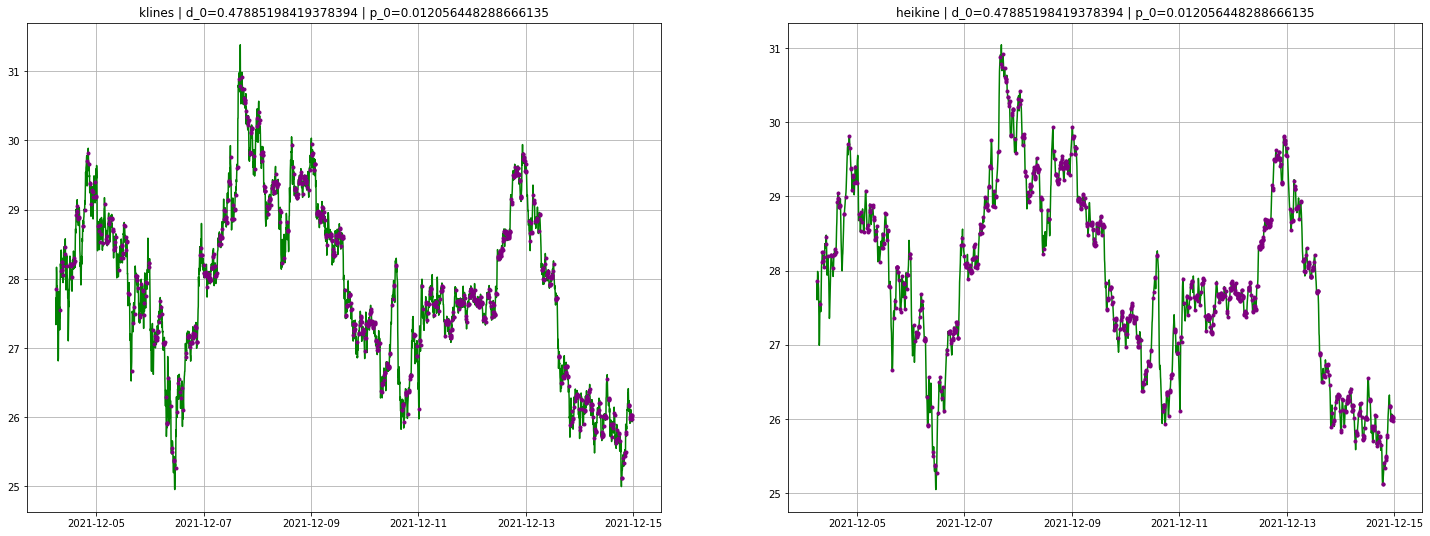

In [319]:
fig, ax = plt.subplots(1, 2, figsize=(25, 9), sharex=True)
ax[0].plot(index, SS, c='green')
ax[1].plot(index, heikin2, c='green')

for q in Q2:
    ax[0].plot([index[0], index[-1]], [q, q], c='b')
    ax[1].plot([index[0], index[-1]], [q, q], c='b')
    
for i in range(len(D2)):
    d = D2[i]
    d2 = arr[i]
    if d<=np.mean(D)*d_0: ### delta porcentual
        ax[0].plot(index[i], d2, ".", c='purple')
        ax[1].plot(index[i], d2, ".", c='purple')

ax[0].set_title(f'klines | d_0={d_0} | p_0={p_0}')
ax[1].set_title(f'heikine | d_0={d_0} | p_0={p_0}')

ax[0].grid()
ax[1].grid()

In [260]:
# fig = plt.figure(figsize=(18, 5))
# # plt.hist(D)
# # plt.grid()
# plt.plot(D, "o")
# plt.grid()

In [323]:
# fig, ax = plt.subplots(1, 2, figsize=(22, 6), sharex=True)
# ax[0].plot(index, SS, c='green')
# ax[1].plot(index, heikin, c='green')

# ax[0].grid()
# ax[1].grid()

In [322]:
# D2 = [0] + D
# W = []
# fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
# ax[0].plot(index, heikin, c='green')
# ax[1].plot(index, D2, c='orange')

# for i in range(len(D2)):
#     d = D2[i]
#     d2 = arr[i]
#     if d<=0.02:
#         W.append([index[i], d2])
#         ax[0].plot(index[i], d2, ".", c='purple')

# ax[0].grid()
# ax[1].grid()

# arr_w = np.array(W)[:, 1]

In [310]:
# fig = plt.figure(figsize=(18, 7))
# plt.plot(index, heikin, c='green')
# plt.plot(index, heikin, c='green')

# for q in Q2:
#     plt.plot([index[0], index[-1]], [q, q], c='b')
    
# for i in range(len(D2)):
#     d = D2[i]
#     d2 = arr[i]
#     if d<=0.02:
#         plt.plot(index[i], d2, ".", c='purple')
    
# plt.grid()

In [290]:
# plt.figure(figsize=(20, 6))
# plt.hist(D, bins=100)
# plt.grid()

In [304]:
# fig, ax = plt.subplots(2, 1, figsize=(18, 12), sharex=True)
# ax[0].plot(index, heikin, c='green')
# ax[1].plot(index, D2, c='orange')

# for q in Q2:
#     ax[0].plot([index[0], index[-1]], [q, q], c='b')

# for i in range(len(D2)):
#     d = D2[i]
#     d2 = arr[i]
#     if d<=0.02:
#         ax[0].plot(index[i], d2, ".", c='purple')

# ax[0].grid()
# ax[1].grid()

In [302]:
# plt.figure(figsize=(20, 6))
# plt.plot(arr_w, "o")
# plt.grid()

In [248]:
# plt.figure(figsize=(18, 7))
# plt.plot(index, SS, c='green')
# for q in Q2:
#     plt.plot([index[0], index[-1]], [q, q], c='b')
# plt.grid()
# plt.show()